# Import

In [ ]:
#import libraries an needed tools
import datetime
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Trading Strategy / Creating Signals 

In [ ]:
#Definition of Stocks we use for our trading
#Other Stocks examples you can fill in would be:
# Tesla = TSLA, Nestle = NESM, PepsiCo = PEP, CocaCola = CCC3, 3M = MMM etc.
stocks = ["MSFT", "AAPL", "BNTX"]
s_1 = stocks[0]
s_2 = stocks[1]
s_3 = stocks[2]

# Set a timeframe to analyse stocks 
end = datetime.datetime.today()
date365 = datetime.timedelta(days=365)
start = end - date365
data = pdr.DataReader(stocks, 'yahoo', start, end)

# Define the length of the shortterm and the longterm window of the momentum strategy 
# Those numbers can be changed for example to 50 / 200 to change the momentum strategy
short_window = 20
long_window = 100
#Setting Dataframe for Signals for each stock
signals = pd.DataFrame(index=data.index)
signals['signal1'] = 0.0
signals['signal2'] = 0.0
signals['signal3'] = 0.0
# calculate short and long mvag for all 3 stocks by creating new columns
signals['short_mavg1'] = data['Close'][s_1].rolling(window=short_window, min_periods=1, center=False).mean()
signals['short_mavg2'] = data['Close'][s_2].rolling(window=short_window, min_periods=1, center=False).mean()
signals['short_mavg3'] = data['Close'][s_3].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg1'] = data['Close'][s_1].rolling(window=long_window, min_periods=1, center=False).mean()
signals['long_mavg2'] = data['Close'][s_2].rolling(window=long_window, min_periods=1, center=False).mean()
signals['long_mavg3'] = data['Close'][s_3].rolling(window=long_window, min_periods=1, center=False).mean()
# Create signals where shortmavg is > longmavg as 1 and else 0
signals['signal1'][short_window:] = np.where(signals['short_mavg1'][short_window:]
                                             > signals['long_mavg1'][short_window:], 1.0, 0.0)
signals['signal2'][short_window:] = np.where(signals['short_mavg2'][short_window:]
                                             > signals['long_mavg2'][short_window:], 1.0, 0.0)
signals['signal3'][short_window:] = np.where(signals['short_mavg3'][short_window:]
                                             > signals['long_mavg3'][short_window:], 1.0, 0.0)
# Generate trading orders
signals['positions1'] = signals['signal1'].diff()
signals['positions2'] = signals['signal2'].diff()
signals['positions3'] = signals['signal3'].diff()

# Show signals info and values
print(signals.info())
print(signals)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2019-12-20 to 2020-12-18
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   signal1      252 non-null    float64
 1   signal2      252 non-null    float64
 2   signal3      252 non-null    float64
 3   short_mavg1  252 non-null    float64
 4   short_mavg2  252 non-null    float64
 5   short_mavg3  252 non-null    float64
 6   long_mavg1   252 non-null    float64
 7   long_mavg2   252 non-null    float64
 8   long_mavg3   252 non-null    float64
 9   positions1   251 non-null    float64
 10  positions2   251 non-null    float64
 11  positions3   251 non-null    float64
dtypes: float64(12)
memory usage: 25.6 KB
None
            signal1  signal2  signal3  ...  positions1  positions2  positions3
Date                                   ...                                    
2019-12-20      0.0      0.0      0.0  ...         NaN         NaN         NaN
2019

# Plot and Development of the 3 Stocks 

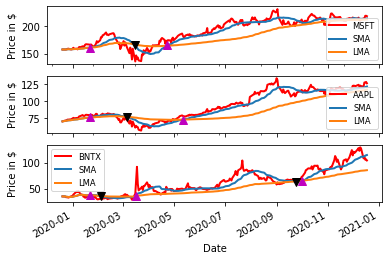

In [ ]:
# Add subplots and label for x- and y-axis for stocks
ax1 = plt.subplot(311, ylabel="Price in $")
data['Close'][s_1].plot(ax=ax1, color='r', lw=2.)
ax2 = plt.subplot(312, sharex=ax1, ylabel="Price in $")
data['Close'][s_2].plot(ax=ax2, color='r', lw=2.)
ax3 = plt.subplot(313, ylabel='Price in $')
data['Close'][s_3].plot(ax=ax3, color='r', lw=2.)

# Plot the short and long moving averages of each stock
signals[['short_mavg1', 'long_mavg1']].plot(ax=ax1, lw=2.)
signals[['short_mavg2', 'long_mavg2']].plot(ax=ax2, lw=2.)
signals[['short_mavg3', 'long_mavg3']].plot(ax=ax3, lw=2.)
ax1.legend((s_1, "SMA", "LMA"), fontsize="small")
ax2.legend((s_2, "SMA", "LMA"), fontsize="small")
ax3.legend((s_3, "SMA", "LMA"), fontsize="small")

# Plot the buy signals
ax1.plot(signals.loc[signals.positions1 == 1.0].index,
         signals.short_mavg1[signals.positions1 == 1.0],
         '^', markersize=8, color='m')
ax2.plot(signals.loc[signals.positions2 == 1.0].index,
         signals.short_mavg2[signals.positions2 == 1.0],
         '^', markersize=8, color='m')
ax3.plot(signals.loc[signals.positions3 == 1.0].index,
         signals.short_mavg3[signals.positions3 == 1.0],
         '^', markersize=8, color='m')
# Plot the sell signals
ax1.plot(signals.loc[signals.positions1 == -1.0].index,
         signals.short_mavg1[signals.positions1 == -1.0],
         'v', markersize=8, color='k')
ax2.plot(signals.loc[signals.positions2 == -1.0].index,
         signals.short_mavg2[signals.positions2 == -1.0],
         'v', markersize=8, color='k')
ax3.plot(signals.loc[signals.positions3 == -1.0].index,
         signals.short_mavg3[signals.positions3 == -1.0],
         'v', markersize=8, color='k')
plt.show()

# Using Signals in a Simulation 

In [ ]:
# backtester
# Set the initial capital
initial_capital = float(300000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares for each stock when the signal is 1 (buy)
positions['stock'] = 100 * signals['signal1'] + 100 * signals['signal2'] + 100 * signals['signal3']

# Initialize the portfolio with value owned
portfolio = positions.multiply(data['Adj Close'][s_1], axis=0)
portfolio = positions.multiply(data['Adj Close'][s_2], axis=0)
portfolio = positions.multiply(data['Adj Close'][s_3], axis=0)

# Store the difference in shares owned
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['Holdings - Stock 1'] = (positions.multiply(data['Adj Close'][s_1], axis=0)).sum(axis=1)
portfolio['Holdings - Stock 2'] = (positions.multiply(data['Adj Close'][s_2], axis=0)).sum(axis=1)
portfolio['Holdings - Stock 3'] = (positions.multiply(data['Adj Close'][s_3], axis=0)).sum(axis=1)
portfolio['Total Holdings'] = portfolio['Holdings - Stock 1'] + \
                              portfolio['Holdings - Stock 2'] + portfolio['Holdings - Stock 3']
# Add `cash` column to portfolio which is the difference between inital capital and invested capital
portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Adj Close'][s_1], axis=0)).sum(axis=1).cumsum()\
                    - (pos_diff.multiply(data['Adj Close'][s_2], axis=0)).sum(axis=1).cumsum()\
                    - (pos_diff.multiply(data['Adj Close'][s_3], axis=0)).sum(axis=1).cumsum()
# Add `total` to portfolio - holdings + cash
portfolio['total'] = portfolio['cash'] + portfolio['Total Holdings']
# Add `returns` to portfolio which is defined as pct change
portfolio['returns'] = portfolio['total'].pct_change()

# show portfolio dataframe and values
print(portfolio.info())
print(portfolio)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2019-12-20 to 2020-12-18
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stock               252 non-null    float64
 1   Holdings - Stock 1  252 non-null    float64
 2   Holdings - Stock 2  252 non-null    float64
 3   Holdings - Stock 3  252 non-null    float64
 4   Total Holdings      252 non-null    float64
 5   cash                252 non-null    float64
 6   total               252 non-null    float64
 7   returns             251 non-null    float64
dtypes: float64(8)
memory usage: 17.7 KB
None
                   stock  Holdings - Stock 1  ...          total   returns
Date                                          ...                         
2019-12-20      0.000000            0.000000  ...  300000.000000       NaN
2019-12-23      0.000000            0.000000  ...  300000.000000  0.000000
2019-12-24      0.000000            0.000

# Plot simulated Portfolio

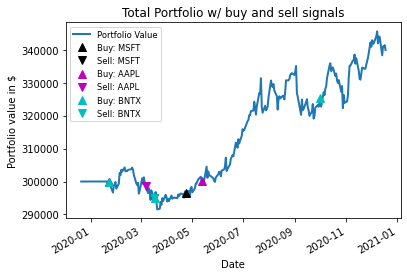

In [ ]:
# plot portfolio overview
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)
# Plot the "buy" trades against the equity curve - Stock 1
ax1.plot(portfolio.loc[signals.positions1 == 1.0].index,
        portfolio.total[signals.positions1 == 1.0],
        '^', markersize=8, color='k')
# Plot the "sell" trades against the equity curve - Stock 1
ax1.plot(portfolio.loc[signals.positions1 == -1.0].index,
        portfolio.total[signals.positions1 == -1.0],
        'v', markersize=8, color='k')
# Plot the "buy" trades against the equity curve - Stock 2
ax1.plot(portfolio.loc[signals.positions2 == 1.0].index,
        portfolio.total[signals.positions2 == 1.0],
        '^', markersize=8, color='m')
# Plot the "sell" trades against the equity curve - Stock 2
ax1.plot(portfolio.loc[signals.positions2 == -1.0].index,
        portfolio.total[signals.positions2 == -1.0],
        'v', markersize=8, color='m')
# Plot the "buy" trades against the equity curve - Stock 3
ax1.plot(portfolio.loc[signals.positions3 == 1.0].index,
        portfolio.total[signals.positions3 == 1.0],
        '^', markersize=8, color='c')
# Plot the "sell" trades against the equity curve - Stock 3
ax1.plot(portfolio.loc[signals.positions1 == -1.0].index,
         portfolio.total[signals.positions1 == -1.0],
         'v', markersize=8, color='c')
plt.title("Total Portfolio w/ buy and sell signals")
plt.legend(('Portfolio Value', "Buy: %s" % s_1, 'Sell: %s' % s_1, 'Buy: %s'
            % s_2, 'Sell: %s' % s_2, 'Buy: %s' % s_3, 'Sell: %s' % s_3), fontsize="small")
plt.show()